# TDA On stage 2 outputs
* The second stage of devograph is to convert a csv file into a temporal and directed graph. The csv file contains information of embryogenesis of C. elegans 
* We use a sample csv file in this notebook for presentation, of which the link is https://github.com/devoworm/DevoWorm/blob/master/Caenorhabditis%20elegans%20raw%20nuclei%20data/raw-data-part-1a.csv

In [2]:
import sys
# sys.path.append('/home/ubuntu/DevoGraph')
sys.path.append('/home/hrc/gsoc/d-gnn/DevoGraph/')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import networkx as nx
import numpy as np
import torch as th


from copy import deepcopy
from importlib import reload
import devograph.datasets.datasets as data

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
reload(data)

<module 'devograph.datasets.datasets' from '/home/hrc/gsoc/d-gnn/DevoGraph/devograph/datasets/datasets.py'>

In [5]:
# The default directory that stores all input and output data of DevoGraph is ~/.CEData/
data_path = '~/.CEData/'
# data_path = '/home/hrc/gsoc/d-gnn/DevoGraph/data/.CEData/'

## Pre-process sampled data
* This part is to pre-process the csv file obtained from https://github.com/devoworm/DevoWorm/blob/master/Caenorhabditis%20elegans%20raw%20nuclei%20data/raw-data-part-1a.csv into the input csv file of the second stage. The input csv file should contains following columns:
    * cell: cell name
    * time: the timestamp when the cell information is sampled
    * x, y, z: the 3-D positions
* Moreover, the sample input file in this notebook also contains a column called `size`, which contain volumns of cells observed at different timestamps.

In [6]:
raw_data = pd.read_csv(f'{data_path}raw-data-part-1a.csv')
# raw_data = pd.read_csv('raw-data-part-1a.csv')
raw_data.drop(['cellTime'], axis=1, inplace=True)
raw_data.drop(raw_data[(raw_data.time == 'time')].index, axis=0, inplace=True)
raw_data

,cell,time,x,y,z,size
0,AB,1,454,286,14,53
1,AB,2,494,244,14.5,68
2,AB,3,497,235,14,48
3,AB,4,491,223,14,50
4,ABa,5,519,272,14.3,70
...,...,...,...,...,...,...
252293,Cppp,87,578,205,14.1,40
252294,Cppp,88,583,215,14,40
252295,Cppp,89,573,210,13.1,38
252296,Cpppa,90,562,233,14.8,36


In [7]:
raw_data.time = raw_data.time.astype('int')
raw_data.x = raw_data.x.astype('float')
raw_data.y = raw_data.y.astype('float')
raw_data.z = raw_data.z.astype('float')
raw_data['size'] = raw_data['size'].astype('float')

In [8]:
# raw data here is the input csv file of the second stage
raw_data.to_csv(f'{data_path}CE_lineage_data.csv')

In [9]:
lineage_data = pd.read_excel(f'{data_path}cell-by-cell-data-v2.xlsx', sheet_name='daughter-of-database', 
                             engine='openpyxl', usecols=['CELL NAME', 'CELL NAME.1'])
lineage_data.rename(columns={'CELL NAME': 'daughter', 'CELL NAME.1': 'mother'}, inplace=True)

In [10]:
# lineage data is the cell lineage tree of C. elegans, which is utlized to build the directed graph
lineage_data

,daughter,mother
0,AB,P0
1,ABa,AB
2,ABal,ABa
3,ABala,ABal
4,ABalaa,ABala
...,...,...
1860,Z4.appaaap,Z4.appaaa
1861,Z4.appaap,Z4.appaa
1862,Z4.appap,Z4.appa
1863,Z4.appp,Z4.app


In [11]:
lineage_data.to_csv(f'{data_path}CE_lineage_data.csv')

## Build a DGL graph based on the given sampled data
* This part we build temporal graphs based on input csv file pre-processed by the last part. Given lineage tree information, we also provide an API that connects mother and daughter cells in successive temporal graphs and generates a directed graph.


In [12]:
# import dgl
# from dgl.data import DGLDataset
# from dgl.data.utils import download, save_info, save_graphs, load_graphs, load_info

In [13]:
# load graphs from disk. if there's no existing graphs, download raw data from url then generate temporal
# graphs based on them. The graph building process is based on KNN algorithm. 
datasets = data.CETemporalGraphKNN(
        time_start=0, time_end=10, knn_k=3, columns=['size'],
        url='https://raw.githubusercontent.com/LspongebobJH/DevoGraph/main/data/CE_raw_data.csv?token=GHSAT0AAAAAABMX6RJRRFC2U5QOCZXHNBVYYVL5Y2A')
# datasets = data.CETemporalGraphKNN(
#     raw_dir='/home/hrc/gsoc/d-gnn/DevoGraph/data/.CEData/', 
#     save_dir='/home/hrc/gsoc/d-gnn/DevoGraph/data/.CEData/',
#     time_start=0, 
#     time_end=10, 
#     knn_k=3, 
#     columns=['size'], 
#     url='https://github.com/DevoLearn/DevoGraph/blob/main/data/CE_raw_data.csv'
#     )
# datasets = data.CETemporalGraphKNN(name='CETemporalGraph', url=None, raw_dir=data_path, save_dir=data_path, 
#                  hash_key=(), force_reload=False, verbose=False, transform=None, 
#                  knn_k=3, knn_algorithm='bruteforce-blas', knn_dist='euclidean', 
#                  time_start=0, time_end=10, columns=['size'])
# convert the temporal graph datasets into a batch graph with directed links that connect 
# mother and daughter cells across successive frames according to the cell lineage tree given in the second param.
res_g, batch_node_interval = data.to_temporal_directed(datasets, '~/.CEData/CE_lineage_data.csv')

# store the directed temporal graphs and related information into datasets for later operations
datasets.set_batch_graph(res_g)
datasets.set_info({'batch_node_interval': batch_node_interval})

In [14]:
print(f"number of frames: {len(datasets)}")
print(f"number of nodes in the batch graph: {datasets.batch_graph.number_of_nodes()}")
print(f"number of edges in the batch graph: {datasets.batch_graph.number_of_edges()}")

number of frames: 10
number of nodes in the batch graph: 627
number of edges in the batch graph: 5397


# TDA On the graph

In [15]:
import numpy as np
from numpy.random import default_rng
rng = default_rng(42)  # Create a random number generator

from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix

from gtda.graphs import GraphGeodesicDistance
from gtda.homology import VietorisRipsPersistence, SparseRipsPersistence, FlagserPersistence

from igraph import Graph

from IPython.display import SVG, display

from gtda.plotting import plot_diagram


In [16]:
from ripser import Rips
import persim

Testing the function

In [50]:
# Create a single weighted adjacency matrix of a FCW graph
n_vertices = 10
x = rng.random((n_vertices, n_vertices))
# Fill the diagonal with zeros (not always necessary, see below)
np.fill_diagonal(x, 0)

# Create a trivial collection of weighted adjacency matrices, containing x only
X = [x]

# Instantiate topological transformer
VR = VietorisRipsPersistence(metric="precomputed")

# Compute persistence diagrams corresponding to each entry (only one here) in X
diagrams = VR.fit_transform(X)

print(f"diagrams.shape: {diagrams.shape} ({diagrams.shape[1]} topological features)")

print(x.shape)

diagrams.shape: (1, 13, 3) (13 topological features)
(10, 10)


In [51]:
plot_diagram(diagrams[0])

In [53]:
# print(datasets[2])

test_graph = datasets[3].adj(scipy_fmt='coo')

print(test_graph.get_shape())


# testing best way to extract points from dataset

# test_graph_indices = test_graph.coalesce().indices().numpy() 
# test_graph_values = test_graph.coalesce().values().numpy() 

# print(test_graph_values.shape)
# print(test_graph.coalesce().values().numpy())
# print(test_graph.coalesce().indices().numpy())
# print(test_graph.indices())

print(type(test_graph))

(55, 55)
<class 'scipy.sparse.coo.coo_matrix'>


In [54]:
print(test_graph)

  (0, 0)	1
  (19, 0)	1
  (14, 0)	1
  (1, 1)	1
  (42, 1)	1
  (11, 1)	1
  (2, 2)	1
  (28, 2)	1
  (20, 2)	1
  (3, 3)	1
  (12, 3)	1
  (11, 3)	1
  (4, 4)	1
  (13, 4)	1
  (14, 4)	1
  (5, 5)	1
  (36, 5)	1
  (44, 5)	1
  (6, 6)	1
  (49, 6)	1
  (20, 6)	1
  (7, 7)	1
  (45, 7)	1
  (40, 7)	1
  (8, 8)	1
  :	:
  (38, 46)	1
  (47, 47)	1
  (24, 47)	1
  (23, 47)	1
  (48, 48)	1
  (27, 48)	1
  (5, 48)	1
  (49, 49)	1
  (20, 49)	1
  (6, 49)	1
  (50, 50)	1
  (15, 50)	1
  (43, 50)	1
  (51, 51)	1
  (22, 51)	1
  (8, 51)	1
  (52, 52)	1
  (16, 52)	1
  (26, 52)	1
  (53, 53)	1
  (33, 53)	1
  (9, 53)	1
  (54, 54)	1
  (10, 54)	1
  (23, 54)	1


In [55]:
# demo_graph = test_graph.coalesce().indices().numpy().reshape(17,17)
demo_graph = test_graph
# np.fill_diagonal(demo_graph, 0)
print(demo_graph.shape)
Demo_graph = [demo_graph]

VR = VietorisRipsPersistence(metric="precomputed")

diagrams = VR.fit_transform(Demo_graph)

print(f"diagrams.shape: {diagrams.shape} ({diagrams.shape[1]} topological features)")

print(diagrams)

(55, 55)
diagrams.shape: (1, 7, 3) (7 topological features)
[[[ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  1.]]]


In [56]:
plot_diagram(diagrams[0])

In [57]:
graphs=[]
for i in range(len(datasets)):
    graphs.append(datasets[i].adj(scipy_fmt='coo'))

In [58]:
VR = VietorisRipsPersistence(metric="precomputed")

diagrams = VR.fit_transform(graphs)

print(f"diagrams.shape: {diagrams.shape} ({diagrams.shape[1]} topological features)")
print(diagrams)

diagrams.shape: (10, 11, 3) (11 topological features)
[[[ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [ 1. inf  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [ 1. inf  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1.  1.  0.]
  [ 1.  1.  0.]
  [ 1. inf  1.]
  [ 1. inf  1.]
  [ 1. inf  1.]
  [ 1.  1.  1.]]

 [[ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1.  1.  0.]
  [ 1. inf  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  1.]
  [ 1. inf  1.]
  [ 1. inf  1.]
  [ 1. inf  1.]]

 [[ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. inf  0.]
  [ 1. i

In [59]:
plot_diagram(diagrams[9])

In [60]:
# node features
# pos: 3-D position (x,y,z); size: volumn; time: the timestamp relative to the temporal graph series.
# Note that the node feature `time` is stored in the dataset only when the directed graph has been built.
# datasets[0].ndata.keys()
# print(datasets[0].ndata['pos'])
pos = datasets[0].ndata['pos'].numpy()
r = np.log(np.divide(pos[1:],pos[:len(pos)-1]))
print(r)

[[-0.76151092 -0.00350263  0.13353139]
 [ 0.29590291 -0.30538165  0.20294084]
 [ 0.57008709  0.28051358 -0.20921046]
 [-0.99146765  0.03533937 -0.07169193]
 [ 0.72989672  0.16598514 -0.02047853]
 [-0.07212738 -1.07535543  0.08586129]
 [ 0.5080517   0.89538405 -0.19506058]
 [-0.7985077  -0.17670356 -0.06351341]
 [ 0.70236384  0.10745915  0.20661425]
 [-0.1459277   0.02238899  0.24686008]
 [-0.29122692  0.22092707  0.        ]
 [-0.31455509 -0.51974099 -0.20763936]
 [-0.6218224   0.20202663  0.03774033]
 [ 0.77652879 -0.00407333 -0.19724721]
 [ 0.56531381  0.05942342  0.12693071]
 [-0.79263273  0.04143719 -0.02684725]
 [ 0.77736526 -0.04529076  0.14536585]
 [-0.01160555 -0.16775633 -0.02985296]
 [-0.17843806  0.44865872 -0.01219527]
 [-0.46907383 -0.54442562 -0.1239369 ]
 [-0.40175453  0.1956329  -0.02105341]
 [-0.23712979  0.14585188  0.30873548]
 [ 0.97109897  0.26236426  0.22730156]
 [ 0.14611851 -0.84090806 -0.39104673]
 [ 0.22406479  0.35540025  0.15327387]
 [-1.2732288   0.03077166

In [61]:
print(len(datasets))

10


In [62]:
rips = Rips(maxdim=2)

w = 2
n = len(datasets)-(2*w)+1
w_dist = np.zeros((n,1))

for i in range(n):
    dgm1 = rips.fit_transform(r[i:i+w])
    dgm2 = rips.fit_transform(r[i+w+1:i+(2*w)+1])
    
    w_dist[i] = persim.wasserstein(dgm1[0],dgm2[0],matching=False)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


/home/hrc/anaconda3/envs/test_devo/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

/home/hrc/anaconda3/envs/test_devo/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

/home/hrc/anaconda3/envs/test_devo/lib/python3.8/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/hrc/anaconda3/envs/test_devo/lib/python3.8/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points

/home/hrc/anaconda3/envs/test_devo/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

/home/hrc/anaconda3/envs/test_devo/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more

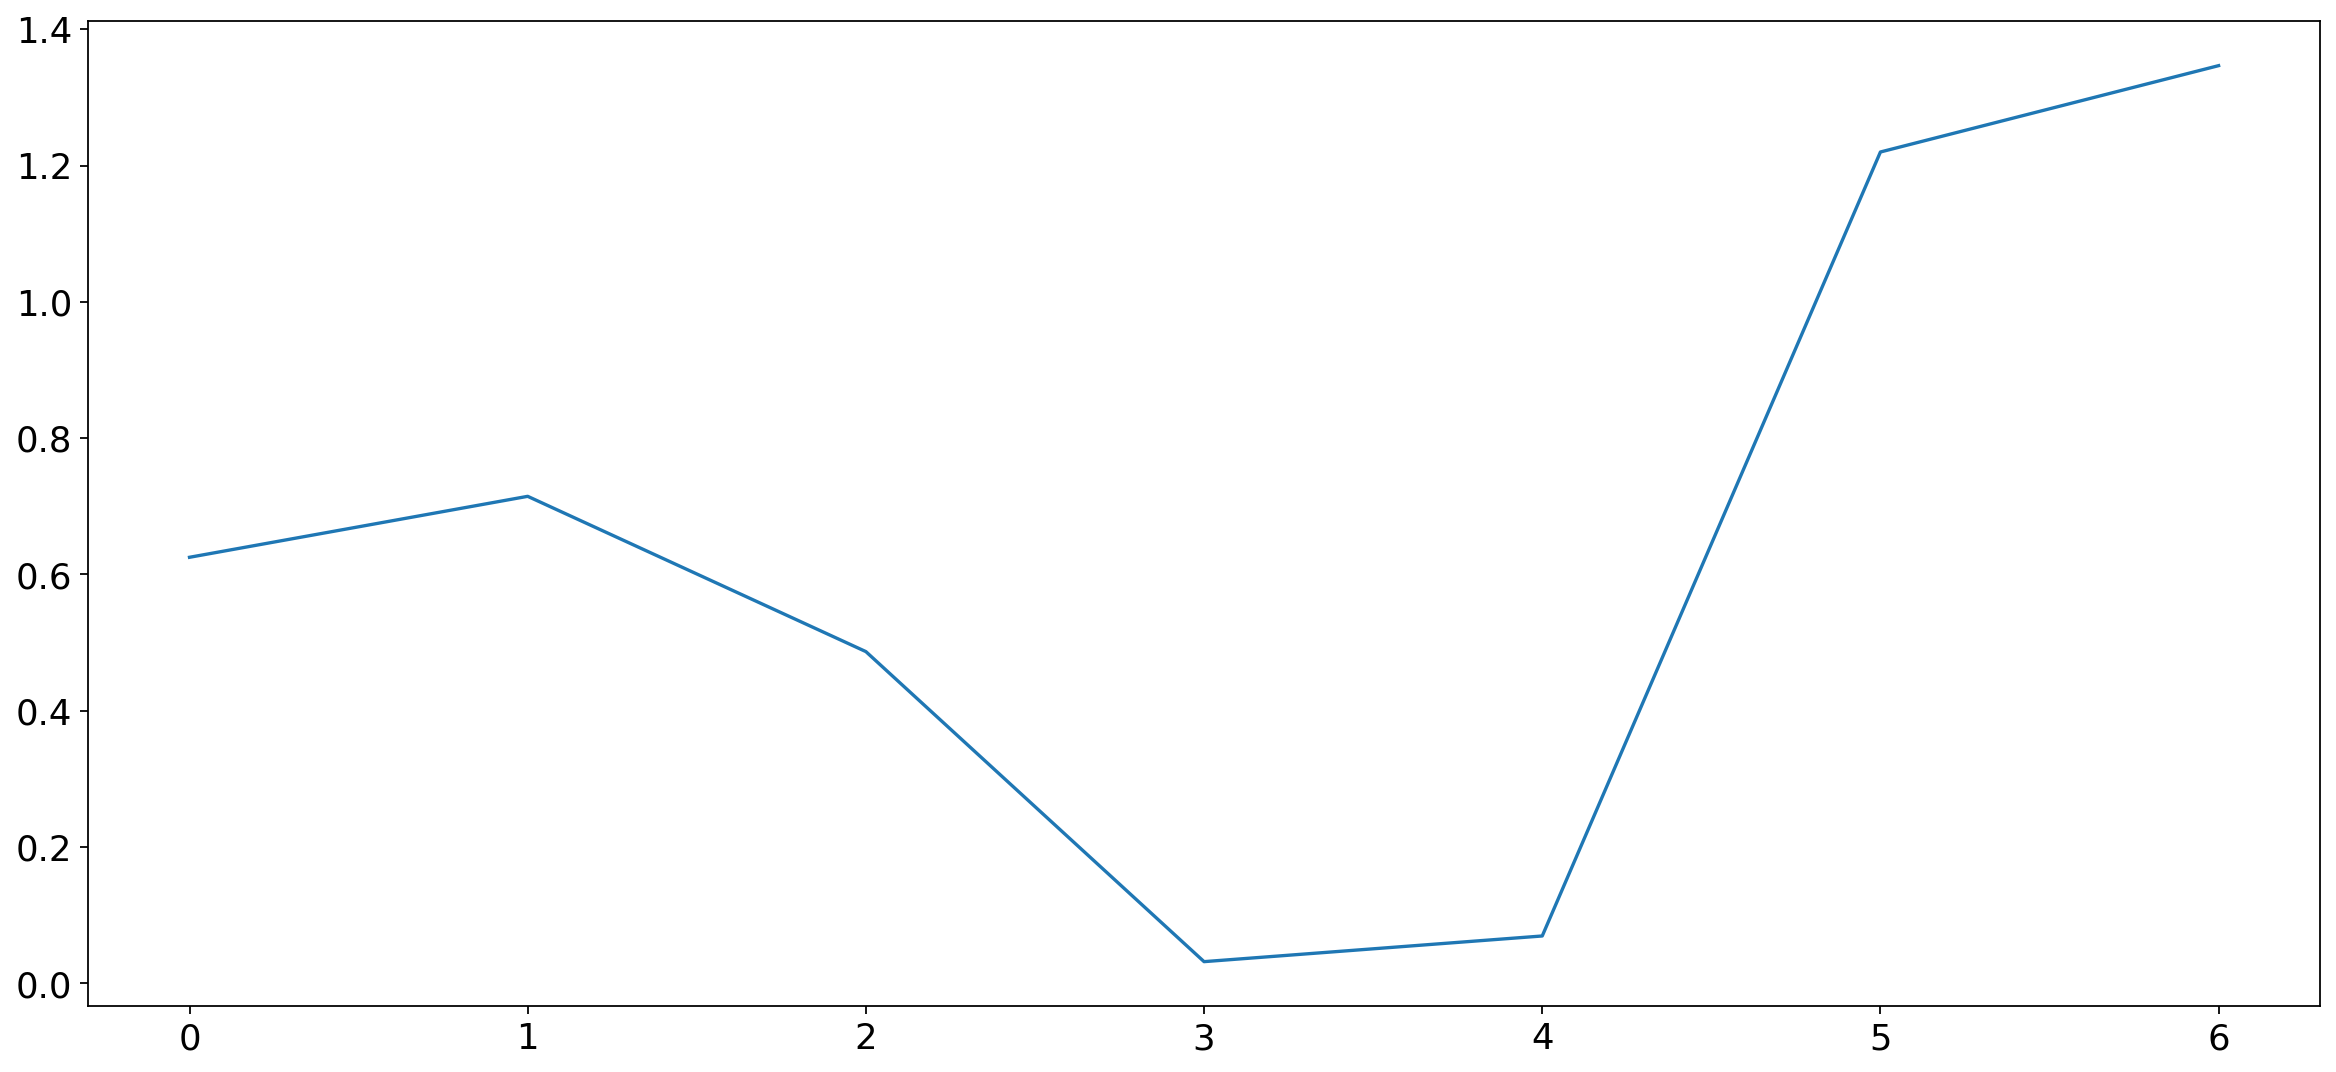

In [63]:
plt.figure(figsize=(18,8),dpi=80)
plt.rcParams.update({'font.size': 16})

plt.plot(w_dist)

## Visualization and persistence diagrams 

In [30]:
g = datasets[3]
pos = g.ndata['pos']
edges = np.array(list(zip(g.edges()[0].numpy(), g.edges()[1].numpy())))
edges_coor = pos[edges].numpy()

print(edges)

[[ 0  0]
 [19  0]
 [14  0]
 [ 1  1]
 [42  1]
 [11  1]
 [ 2  2]
 [28  2]
 [20  2]
 [ 3  3]
 [12  3]
 [11  3]
 [ 4  4]
 [13  4]
 [14  4]
 [ 5  5]
 [36  5]
 [44  5]
 [ 6  6]
 [49  6]
 [20  6]
 [ 7  7]
 [45  7]
 [40  7]
 [ 8  8]
 [51  8]
 [31  8]
 [ 9  9]
 [38  9]
 [39  9]
 [10 10]
 [54 10]
 [23 10]
 [11 11]
 [42 11]
 [ 3 11]
 [12 12]
 [ 3 12]
 [18 12]
 [13 13]
 [ 4 13]
 [14 13]
 [14 14]
 [13 14]
 [ 4 14]
 [15 15]
 [43 15]
 [50 15]
 [16 16]
 [52 16]
 [26 16]
 [17 17]
 [28 17]
 [ 2 17]
 [18 18]
 [12 18]
 [ 3 18]
 [19 19]
 [14 19]
 [13 19]
 [20 20]
 [49 20]
 [ 1 20]
 [21 21]
 [26 21]
 [32 21]
 [22 22]
 [51 22]
 [31 22]
 [23 23]
 [34 23]
 [41 23]
 [24 24]
 [47 24]
 [23 24]
 [25 25]
 [29 25]
 [40 25]
 [26 26]
 [21 26]
 [ 9 26]
 [27 27]
 [48 27]
 [ 5 27]
 [28 28]
 [ 2 28]
 [17 28]
 [29 29]
 [25 29]
 [40 29]
 [30 30]
 [50 30]
 [43 30]
 [31 31]
 [22 31]
 [51 31]
 [32 32]
 [12 32]
 [21 32]
 [33 33]
 [53 33]
 [46 33]
 [34 34]
 [41 34]
 [23 34]
 [35 35]
 [54 35]
 [10 35]
 [36 36]
 [37 36]
 [44 36]
 

In [31]:
# VR = VietorisRipsPersistence(metric="precomputed")

# diagrams = VR.fit_transform(edges)

# print(f"diagrams.shape: {diagrams.shape} ({diagrams.shape[1]} topological features)")
# print(diagrams)

In [32]:
g3 = datasets[3]
pos3 = g3.ndata['pos'].numpy()
# print(pos)

g4 = datasets[4]
pos4 = g4.ndata['pos'].numpy()


In [33]:
import numpy as np 
import cv2 

In [34]:
def coor_3d_to_coor_2d(coor_3d):
      
    # Define the camera matrix 
    fx = 800
    fy = 800
    cx = 640
    cy = 480
    camera_matrix = np.array([[fx, 0, cx], 
                              [0, fy, cy], 
                              [0, 0, 1]], np.float32) 

    # Define the distortion coefficients 
    dist_coeffs = np.zeros((5, 1), np.float32) 

    points_list = []

    # Define the 3D point in the world coordinate system 
    for t in range(50):
        x = pos[t][0]
        y = pos[t][1]
        z = pos[t][2]
        # x, y, z = 10, 20, 30
        points_3d = np.array([[[x, y, z]]], np.float32) 

        # Define the rotation and translation vectors 
        rvec = np.zeros((3, 1), np.float32) 
        tvec = np.zeros((3, 1), np.float32) 

        # Map the 3D point to 2D point 
        points_2d, _ = cv2.projectPoints(points_3d, 
                                         rvec, tvec, 
                                         camera_matrix, 
                                         dist_coeffs) 
        points_2d = points_2d.reshape(1,2)
        point = points_2d[0]
        points_list.append(point)

    # Display the 2D point 
    print("2D Point:", points_list) 
    
    return points_list



In [35]:
coor_2d_pos3 = coor_3d_to_coor_2d(pos3)
coor_2d_pos4 = coor_3d_to_coor_2d(pos4)

2D Point: [array([28697.143, 13222.857], dtype=float32), array([12213.333, 15306.667], dtype=float32), array([ 9547.801, 16536.736], dtype=float32), array([13152.82, 12736.41], dtype=float32), array([26390., 14180.], dtype=float32), array([ 9242.739, 13192.328], dtype=float32), array([17609.697, 26661.818], dtype=float32), array([15406.169, 14688.955], dtype=float32), array([32711.43 , 26194.287], dtype=float32), array([24010.078, 10495.748], dtype=float32), array([28206.879, 10925.86 ], dtype=float32), array([12383.59 , 13505.641], dtype=float32), array([13480.765, 12250.701], dtype=float32), array([24592.941, 13468.235], dtype=float32), array([25281.975, 13763.95 ], dtype=float32), array([15917.108, 16528.193], dtype=float32), array([15363.927,  6958.528], dtype=float32), array([ 5989.3975, 15516.145 ], dtype=float32), array([15845.674, 14721.135], dtype=float32), array([28076.62 , 14958.873], dtype=float32), array([10031.304, 15138.385], dtype=float32), array([17487.682,  9963.443],

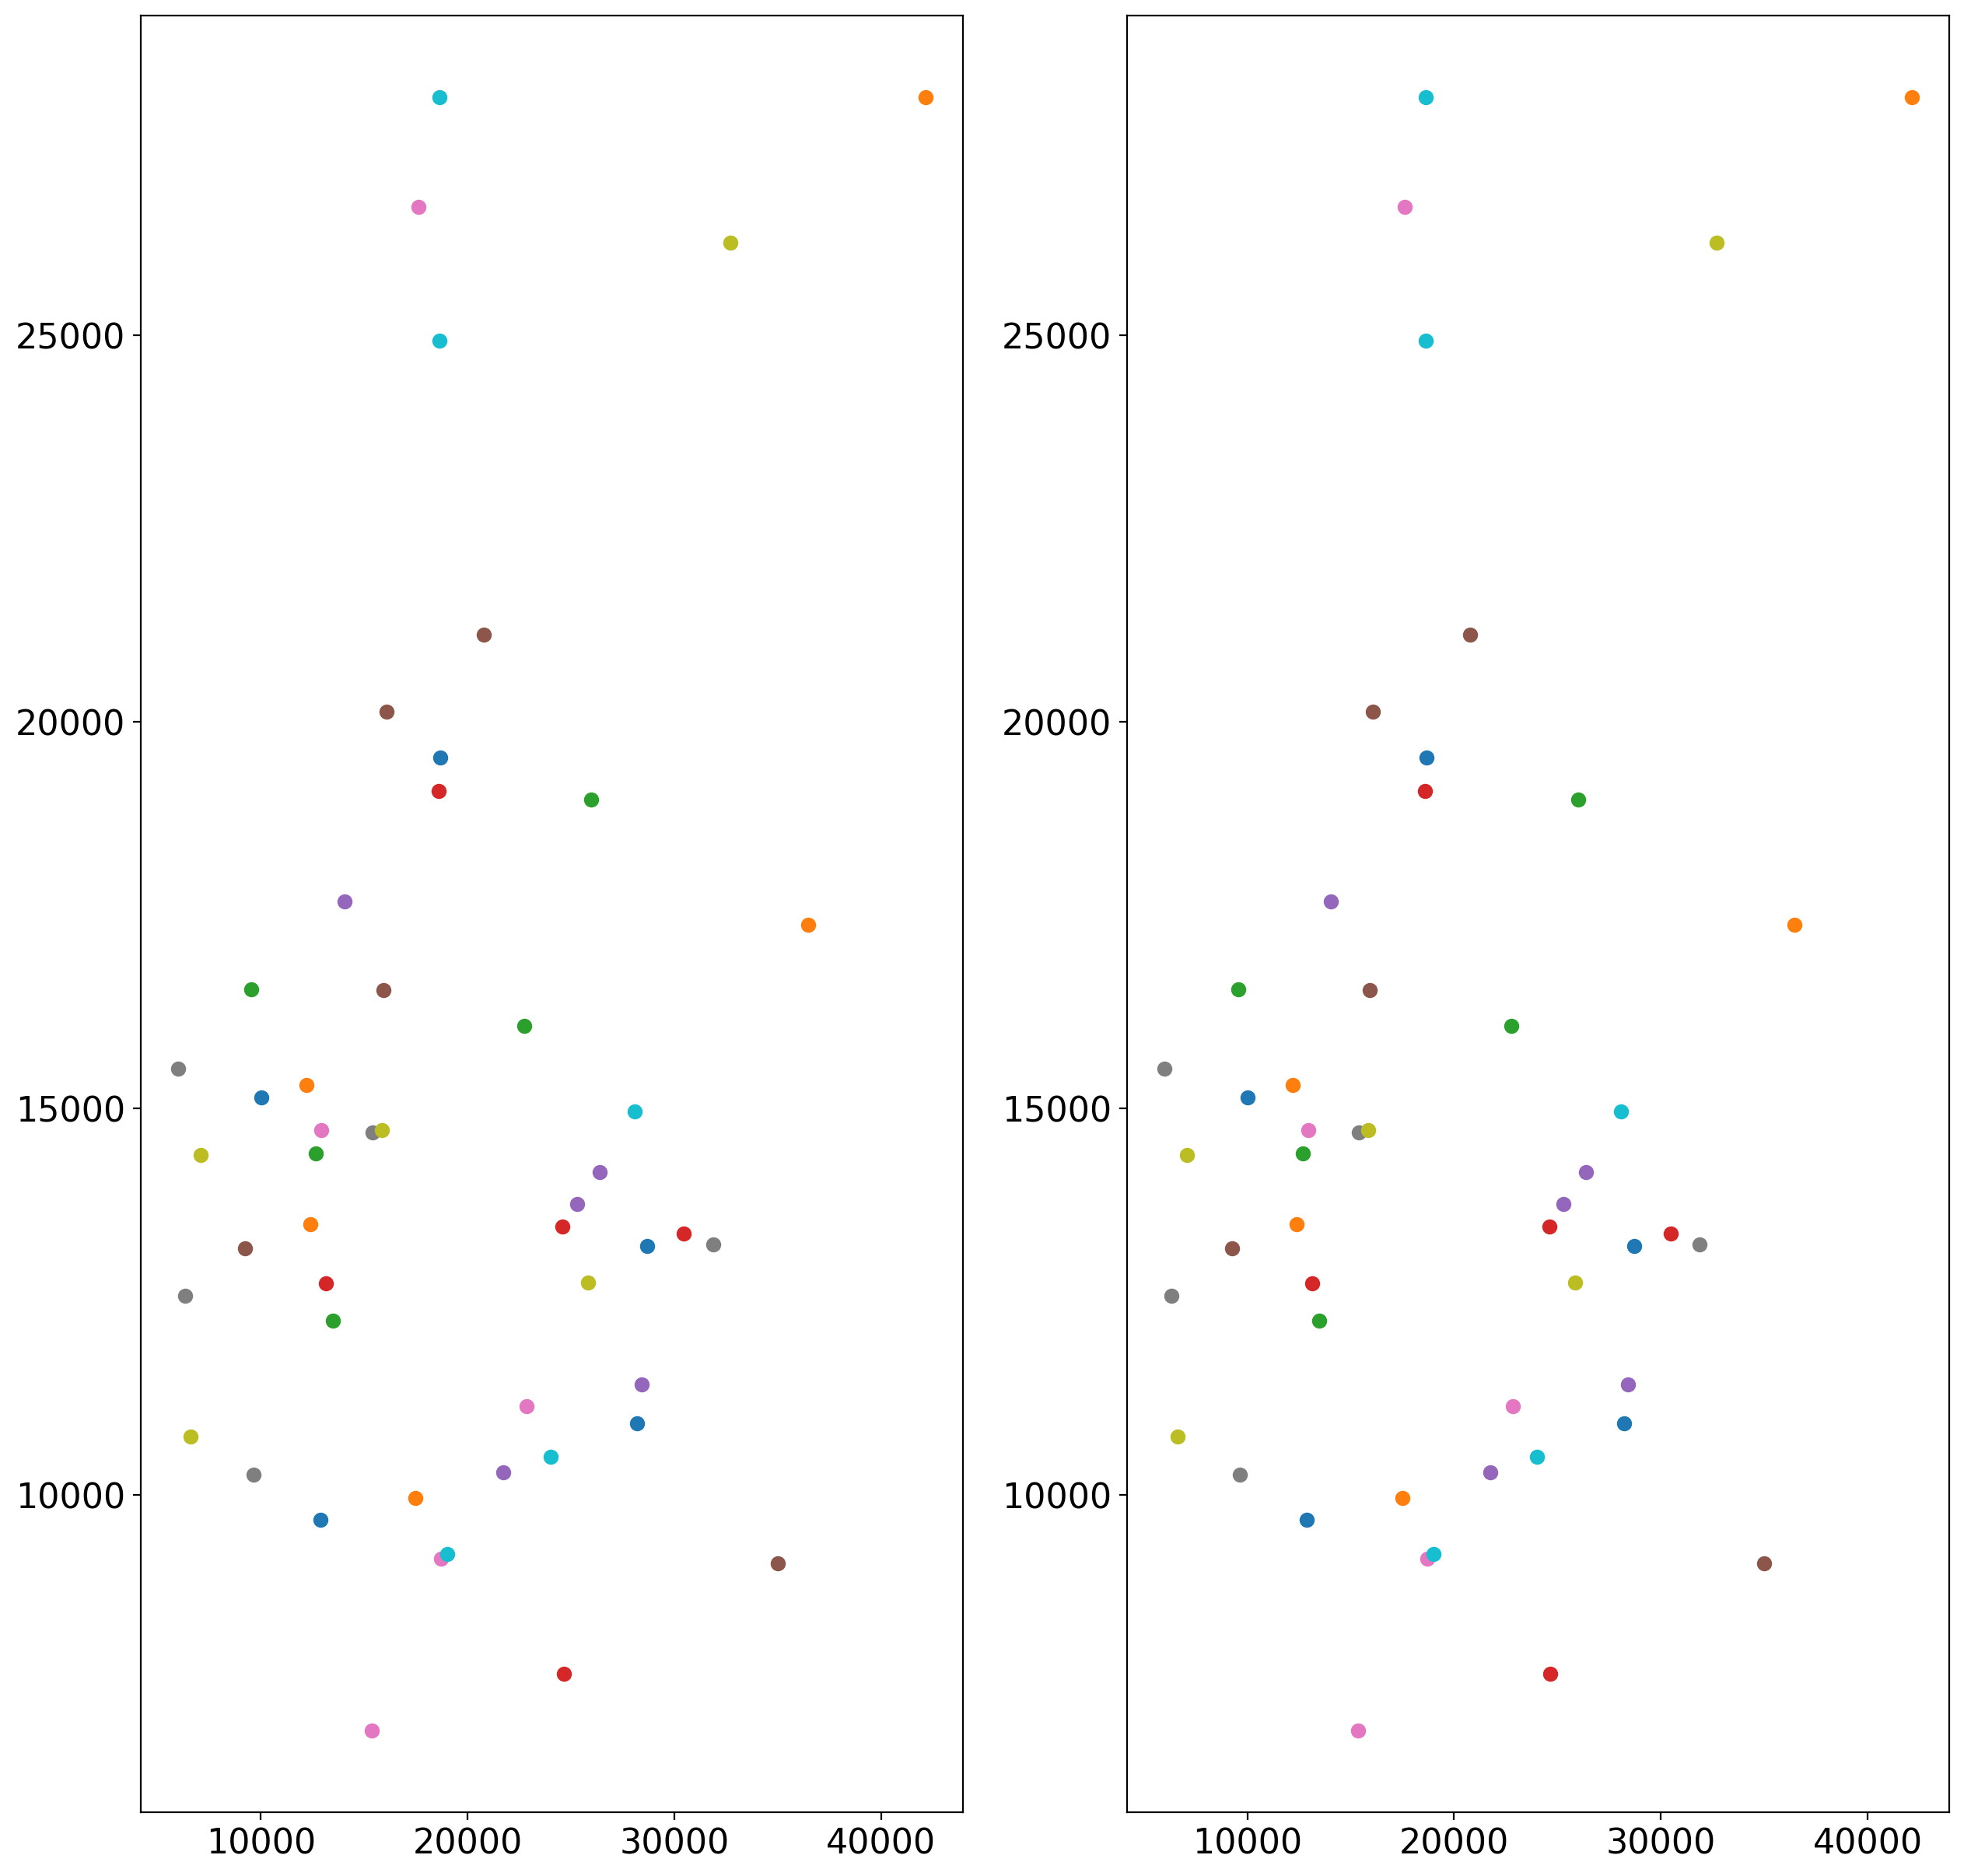

In [36]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(121)
for t in range(50):
    x = coor_2d_pos3[t][0]
    y = coor_2d_pos3[t][1]
    ax.scatter(x, y, label=f'Timestamp {t + 1}')
# ax.scatter(coor_2d_pos3[:, 0], coor_2d_pos3[:, 1], marker='o')

ax = fig.add_subplot(122)
for t in range(50):
    x = coor_2d_pos4[t][0]
    y = coor_2d_pos4[t][1]
    ax.scatter(x, y, label=f'Timestamp {t + 1}')
# ax.scatter(coor_2d_pos4[:, 0], coor_2d_pos4[:, 1], marker='o')

plt.show()

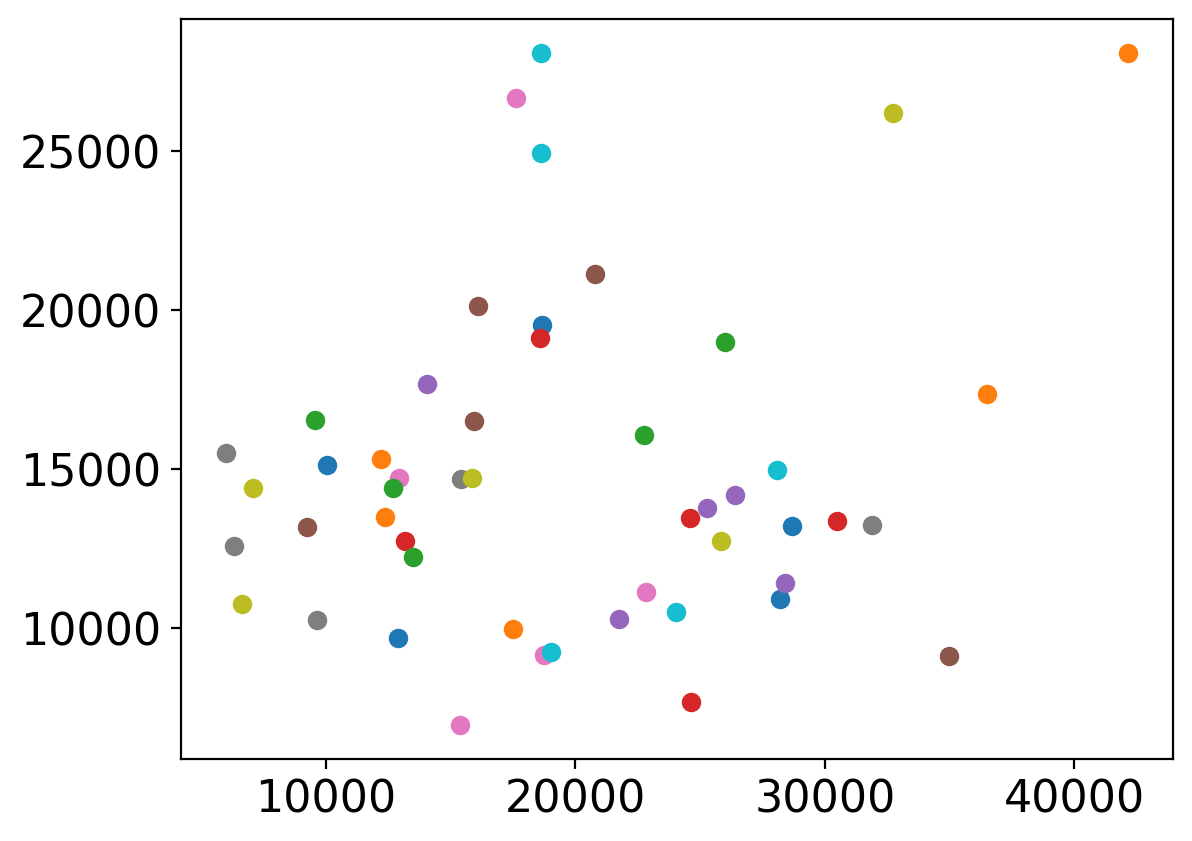

In [64]:
fig = plt.figure()
# ax = fig.add_subplot(11, projection='2d')
for t in range(50):
    x = coor_2d_pos3[t][0]
    y = coor_2d_pos3[t][1]
    plt.scatter(x, y, label=f'Timestamp {t + 1}')
# Set labels for the axes
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# Add a legend
# ax.legend()

# Show the plot
plt.show()

In [65]:
from ripser import ripser
from persim import plot_diagrams

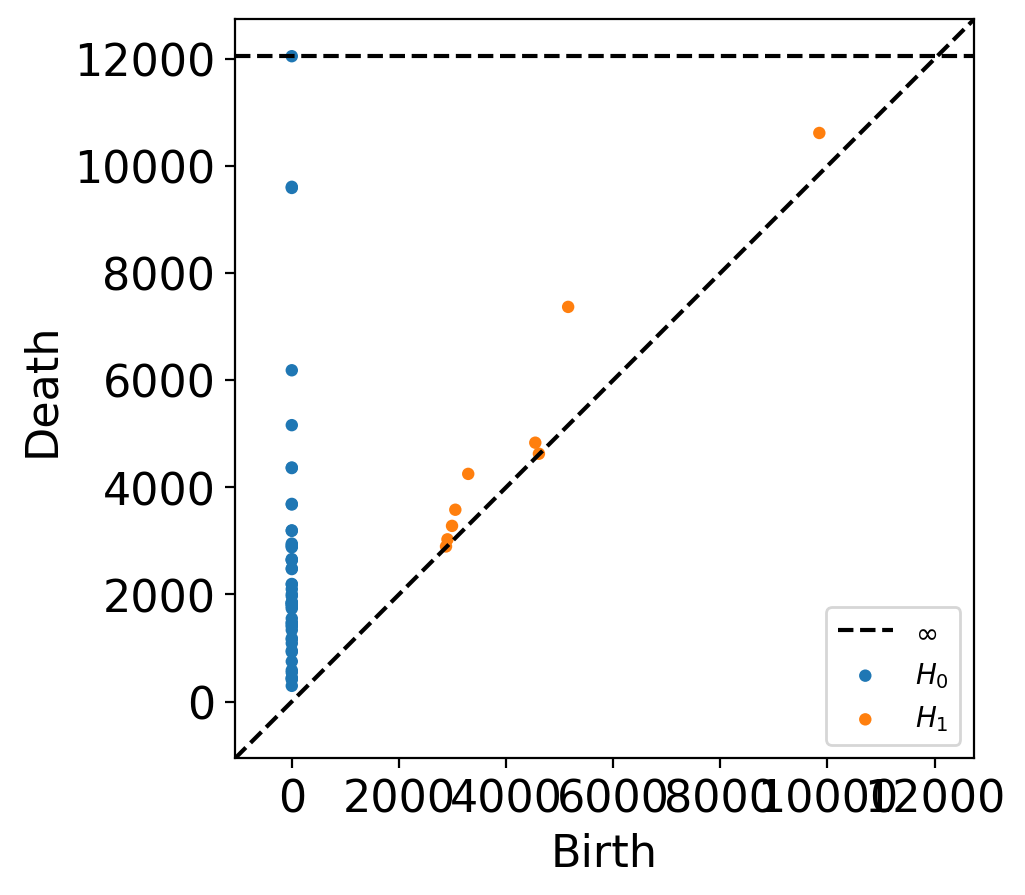

In [66]:
dgms = ripser(np.array(coor_2d_pos3))['dgms']
plot_diagrams(dgms, show=True)

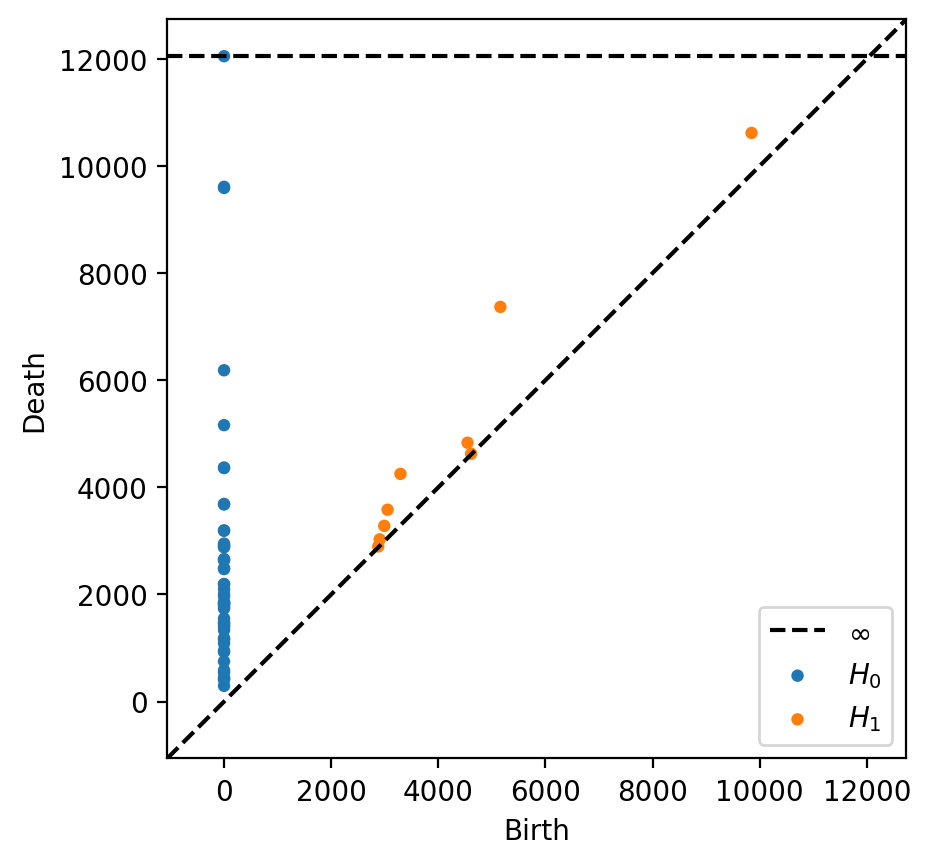

In [67]:
dgms = ripser(np.array(coor_2d_pos4))['dgms']
plot_diagrams(dgms, show=True)

In [73]:

g = datasets[7]
pos = g.ndata['pos']

ax = fig.add_subplot(121, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], marker='o')
edges = np.array(list(zip(g.edges()[0].numpy(), g.edges()[1].numpy())))
edges_coor = pos[edges].numpy()
for edge_coor in edges_coor:
    ax.plot(*edge_coor.T, color='tab:grey')
    
g = datasets[8]
pos = g.ndata['pos']

ax = fig.add_subplot(122, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], marker='o')
edges = np.array(list(zip(g.edges()[0].numpy(), g.edges()[1].numpy())))
edges_coor = pos[edges].numpy()
for edge_coor in edges_coor:
    ax.plot(*edge_coor.T, color='tab:grey')

plt.show()

* Then we visualize two graphs above with directed connections. The blue points are mother cells and the red points are daughter cells. The green dashed lines present connections between mother and daughter cells according to cell lineage tree. 

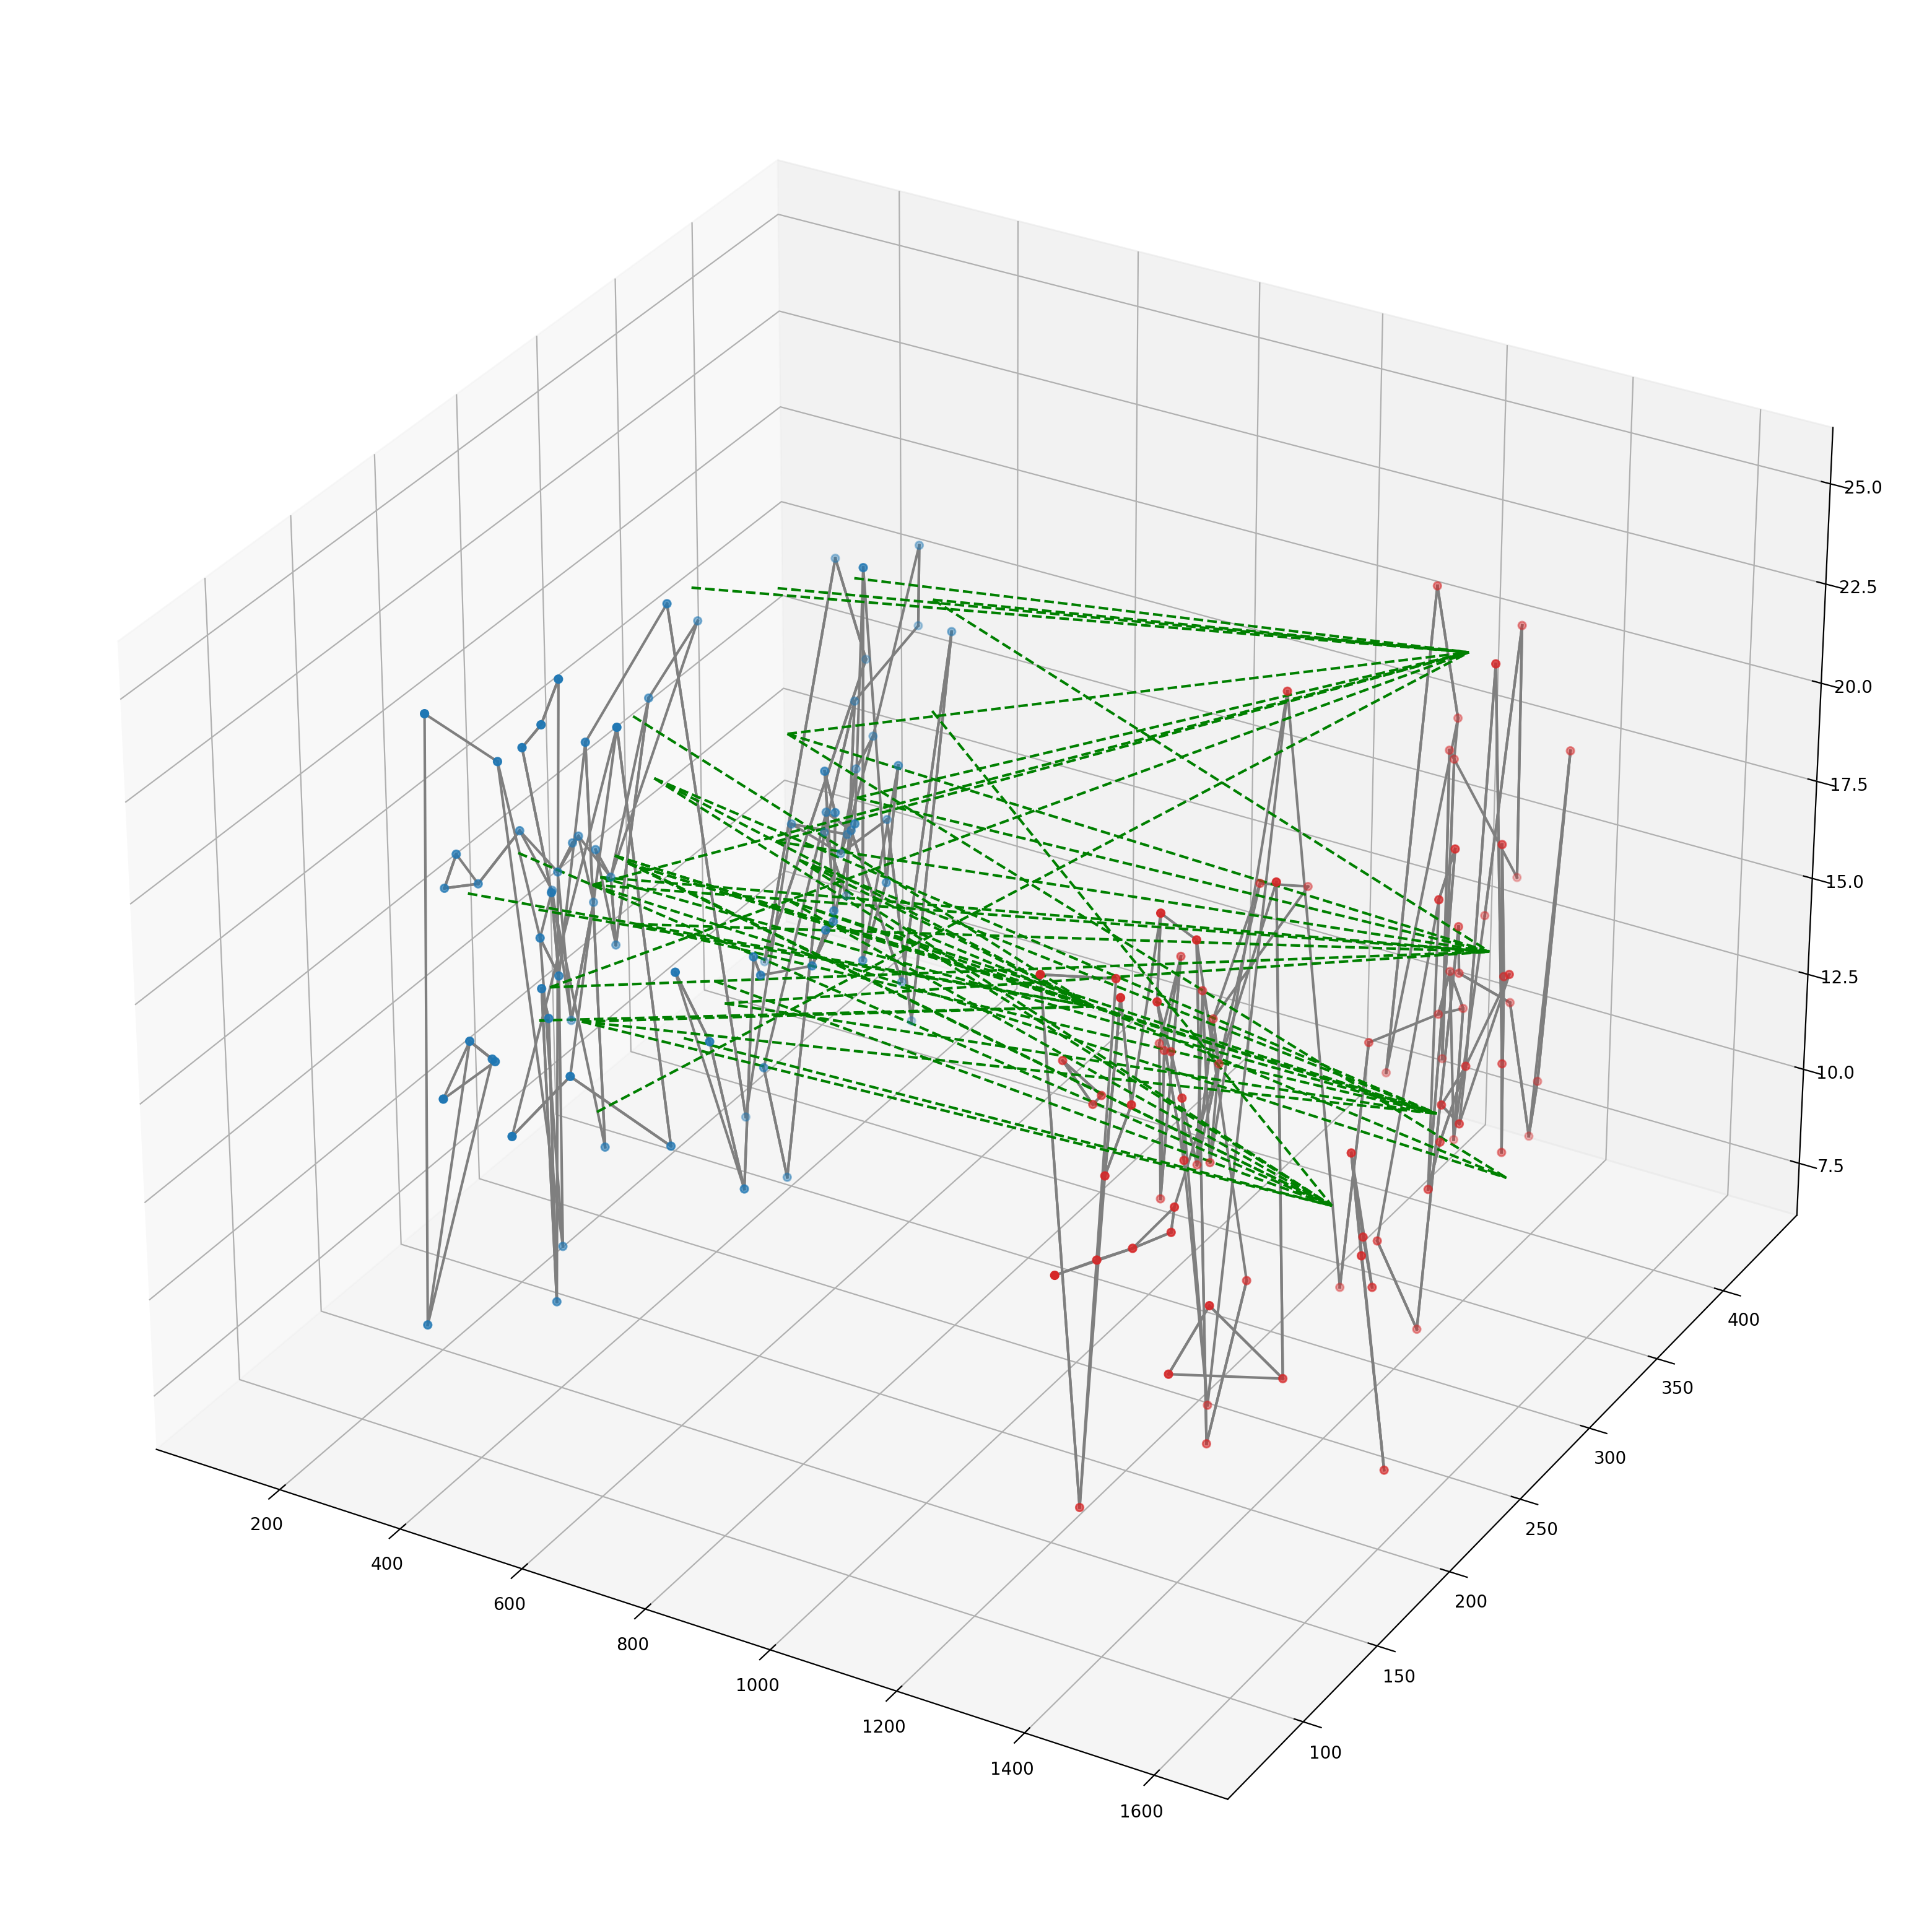

In [69]:
fig = plt.figure(figsize=(20, 20))
batch_graph = datasets.batch_graph
batch_node_interval = datasets.info['batch_node_interval'][3:5]
batch_edges = th.stack(batch_graph.edges()).numpy().T

g1 = deepcopy(datasets[7])
g2 = deepcopy(datasets[8])
pos = batch_graph.ndata['pos']
pos1 = g1.ndata['pos']
pos2 = g2.ndata['pos']
pos2[:, 0] = pos2[:, 0]+1000

ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos1[:, 0], pos1[:, 1], pos1[:, 2], marker='o')
ax.scatter(pos2[:, 0], pos2[:, 1], pos2[:, 2], marker='o', color='tab:red')

edges = np.array(list(zip(g1.edges()[0].numpy(), g1.edges()[1].numpy())))
edges_coor1 = pos1[edges].numpy()
for edge_coor in edges_coor1:
    ax.plot(*edge_coor.T, color='tab:grey')
    
edges = np.array(list(zip(g2.edges()[0].numpy(), g2.edges()[1].numpy())))
edges_coor2 = pos2[edges].numpy()
for edge_coor in edges_coor2:
    ax.plot(*edge_coor.T, color='tab:grey')

cnt=0
for edge in batch_edges:
    if edge[0] in range(batch_node_interval[0][0], batch_node_interval[0][1]) and\
       edge[1] in range(batch_node_interval[1][0], batch_node_interval[1][1]):
        pos_st, pos_ed = pos[edge[0]], pos[edge[1]]
        ax.plot([pos_st[0], pos_ed[0]+1000], [pos_st[1], pos_ed[1]], [pos_st[2], pos_ed[2]], color='green', 
                  linestyle='dashed')
        cnt += 1
    if cnt > 50:
        break

plt.show()

In [70]:
print(edges_coor1)

print(edges_coor2)

[[[572.  248.   14.5]
  [572.  248.   14.5]]

 [[582.  253.   15.3]
  [572.  248.   14.5]]

 [[562.  266.   15. ]
  [572.  248.   14.5]]

 ...

 [[527.  275.   18.4]
  [527.  275.   18.4]]

 [[530.  279.   14.7]
  [527.  275.   18.4]]

 [[531.  280.   17.2]
  [527.  275.   18.4]]]
[[[1578.   261.    14.7]
  [1578.   261.    14.7]]

 [[1567.   253.    15.4]
  [1578.   261.    14.7]]

 [[1562.   272.    15.7]
  [1578.   261.    14.7]]

 ...

 [[1537.   272.    21. ]
  [1537.   272.    21. ]]

 [[1527.   266.    19.9]
  [1537.   272.    21. ]]

 [[1541.   257.    13. ]
  [1537.   272.    21. ]]]
